In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
#from pmdarima import auto_arima
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
data = pd.read_csv('./data/test-1_cpu_usage_data.csv')

In [3]:
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')

In [14]:
data.rename(columns={'date': 'ds', 'cpu used': 'y'}, inplace=True)

In [16]:
#data.reset_index(inplace=True)
data.set_index('ds', inplace=True)

In [17]:
data.head()

,namespace,pods,cpu requested,y,percentage of usage
ds,,,,,
2024-09-07,test-1,54,258.6,91.9,35.54
2024-09-08,test-1,177,606.0,245.7,40.54
2024-09-09,test-1,132,634.1,151.2,23.84
2024-09-10,test-1,108,482.3,144.2,29.90
2024-09-11,test-1,62,250.1,58.9,23.55


In [18]:
df = data[['y']]

In [19]:
df.head()

,y
ds,
2024-09-07,91.9
2024-09-08,245.7
2024-09-09,151.2
2024-09-10,144.2
2024-09-11,58.9


In [171]:
df_resample = df.resample('MS').sum()

<Axes: xlabel='ds'>

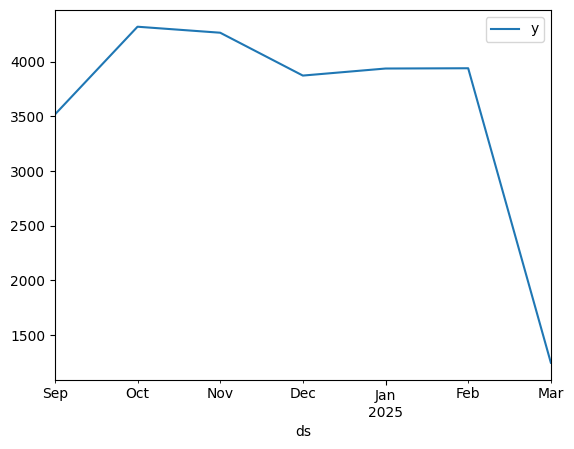

In [172]:
df_resample.plot()

In [23]:
df1 = df.resample('D').sum()

<Axes: xlabel='ds'>

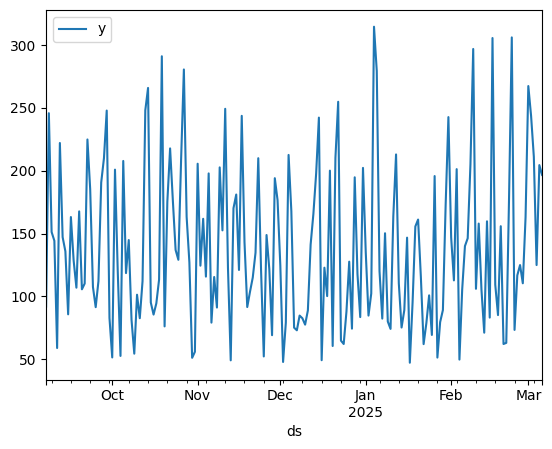

In [24]:
df1.plot()

In [29]:
df1['rollMean']  = df1.y.rolling(window=6).mean()
df1['rollStd']  = df1.y.rolling(window=6).std()

C:\Users\Uttam Kumar\AppData\Local\Temp\ipykernel_7252\2538573906.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


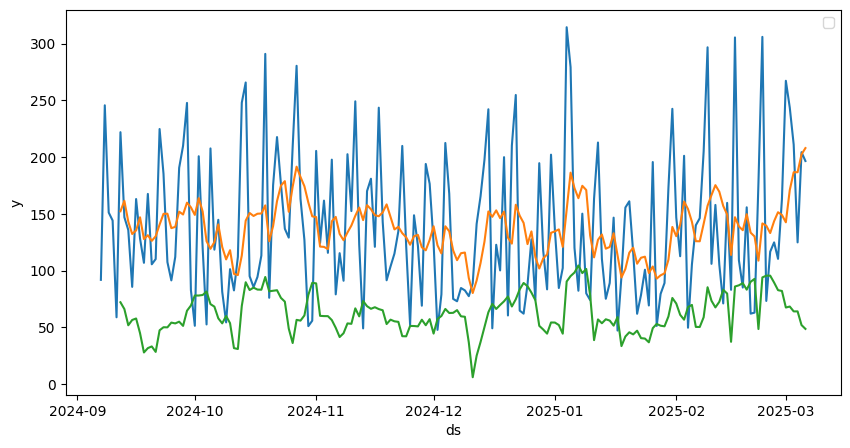

In [31]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df1,x=df1.index,y=df1.y)
sns.lineplot(data=df1,x=df1.index,y=df1.rollMean)
sns.lineplot(data=df1,x=df1.index,y=df1.rollStd)
plt.legend()

In [176]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

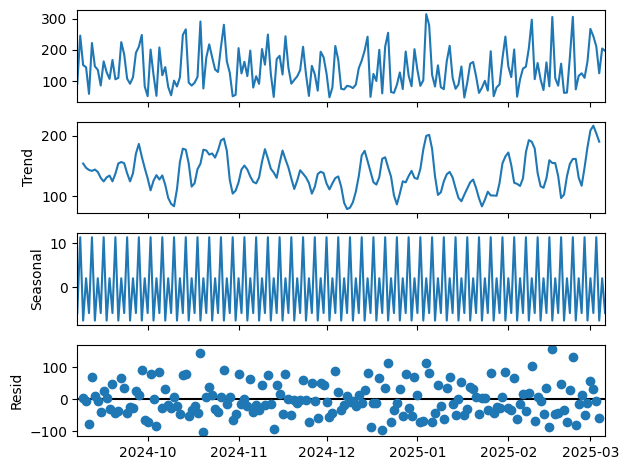

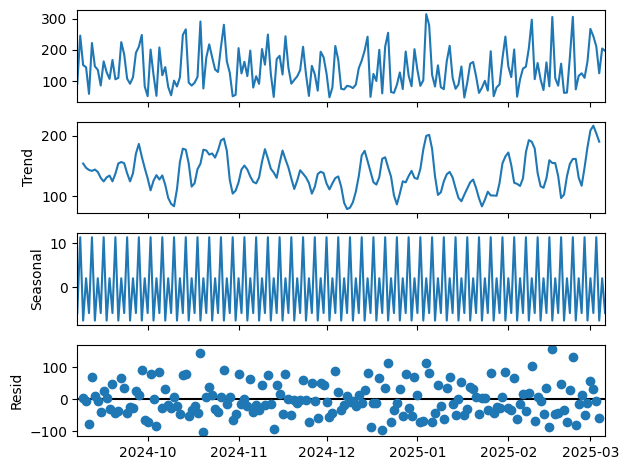

In [184]:
seasonal_decompose(df, model='additive', period=4).plot()

In [249]:
def test_stationarity(dataFrame, var):
    dataFrame['rollMean']  = dataFrame[var].rolling(window=12).mean()
    dataFrame['rollStd']  = dataFrame[var].rolling(window=12).std()
    
    adfTest = adfuller(dataFrame[var],autolag='AIC')
    stats = pd.Series(adfTest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    
    if stats[1] < 0.05:
        print("Interpretation: The original series is Stationary.\n")
    else:
        print("Interpretation: The original series is Non-Stationary.\n")
        
    print(stats)
    
    for key, values in adfTest[4].items():
        print('criticality',key,":",values)
        
    sns.lineplot(data=dataFrame,x=dataFrame.index,y=var)
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollMean')
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollStd')

In [ ]:
#adfTest = adfuller(df['y'],autolag='AIC')
#stats = pd.Series(adfTest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
#stats

In [227]:
df2 = df.resample('D').sum()

Interpretation: The original series is Stationary.

Test Statistic                  -3.878133
p-value                          0.002202
#lags used                      11.000000
number of observations used    169.000000
dtype: float64
criticality 1% : -3.469648263987657
criticality 5% : -2.878798906308495
criticality 10% : -2.5759713094779593


C:\Users\Uttam Kumar\AppData\Local\Temp\ipykernel_7252\3806428952.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if stats[1] < 0.05:


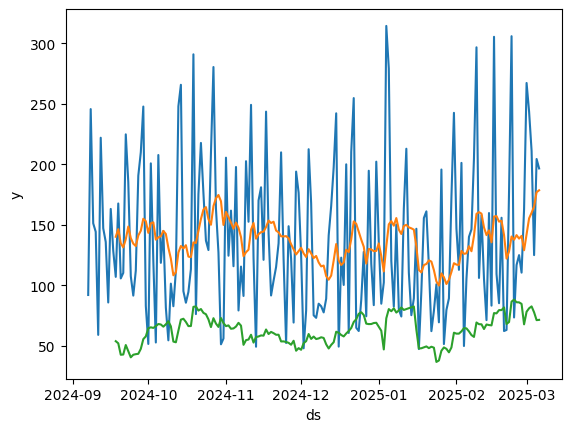

In [229]:
test_stationarity(df2, 'y')

In [230]:
df2.y.mean(), np.sqrt(df2.y.var())

(np.float64(138.66077348066298), np.float64(63.87682728378772))

In [241]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 181 entries, 2024-09-07 to 2025-03-06
Freq: D
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   y           181 non-null    float64
 1   First_Diff  180 non-null    float64
dtypes: float64(2)
memory usage: 4.2 KB


In [242]:
df2.drop(['rollMean', 'rollStd', 'First_Diff'], axis=1, inplace=True)

KeyError: "['rollMean', 'rollStd'] not found in axis"

In [243]:
df2.head()

,y,First_Diff
ds,,
2024-09-07,91.9,NaN
2024-09-08,245.7,153.8
2024-09-09,151.2,-94.5
2024-09-10,144.2,-7.0
2024-09-11,58.9,-85.3


In [254]:
# Apply first-order differencing
df2['First_Diff'] = df2['y'].diff()
adftest = adfuller(df2["First_Diff"].dropna())
adfStats = pd.Series(adftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])

print(adfStats)

for key, values in adftest[4].items():
    print('criticality',key,":",values)
    
if adftest[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")


Test Statistic                -1.098841e+01
p-value                        7.161630e-20
#lags used                     6.000000e+00
number of observations used    1.730000e+02
dtype: float64
criticality 1% : -3.4687256239864017
criticality 5% : -2.8783961376954363
criticality 10% : -2.57575634100705
Interpretation: The original series is Stationary.



In [39]:
df1.head()

,y
ds,
2024-09-07,91.9
2024-09-08,245.7
2024-09-09,151.2
2024-09-10,144.2
2024-09-11,58.9


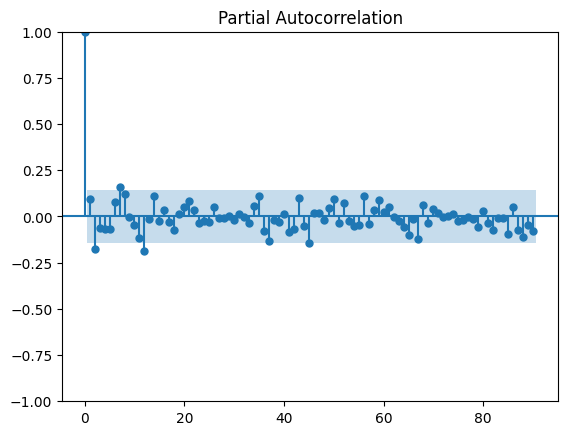

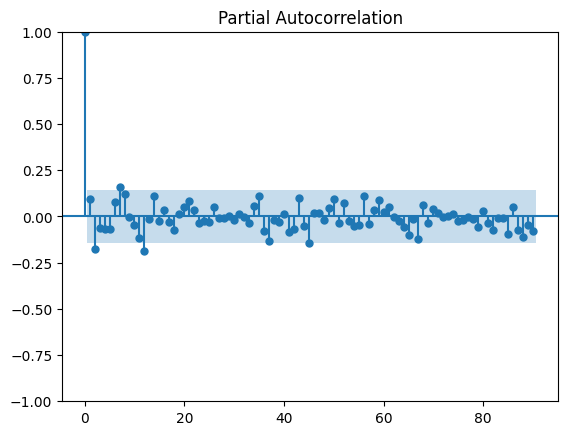

In [70]:
plot_pacf(df1['y'].dropna(),lags=90)

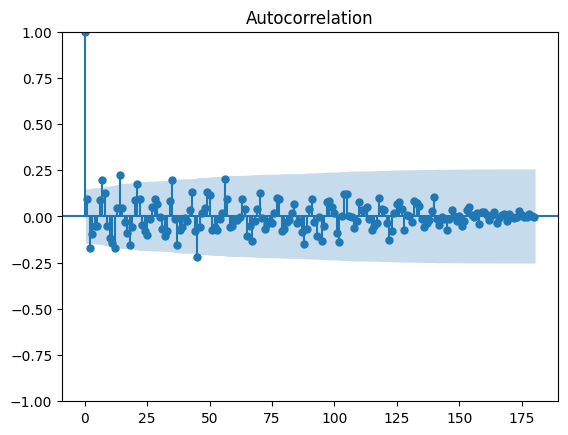

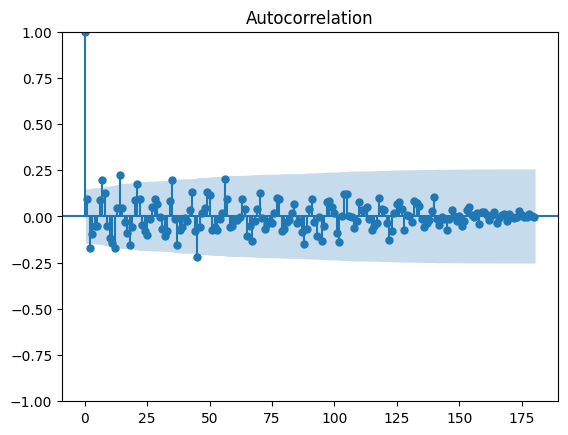

In [69]:
plot_acf(df1['y'].dropna(),lags=180)

In [ ]:
#Split train and test data
df1.drop(['rollMean', 'rollStd'], axis=1, inplace=True)
split_date = df1.index[-30].strftime("%Y-%m-%d")

df_train = df1.loc[df1.index <= split_date].copy()
df_test = df1.loc[df1.index > split_date].copy()

In [52]:
df_train.tail()

,y
ds,
2025-02-01,146.8
2025-02-02,112.7
2025-02-03,201.2
2025-02-04,49.7
2025-02-05,105.4


In [53]:
df_test.head()

,y
ds,
2025-02-06,140.0
2025-02-07,146.2
2025-02-08,205.1
2025-02-09,296.8
2025-02-10,106.0


In [54]:
df_test.shape

(29, 1)

In [207]:
df1.drop(['rollMean', 'rollStd'], axis=1, inplace=True)

In [406]:
model = ARIMA(df_train['y'],order=(6,0,8))
model_fit = model.fit()
prediction = model_fit.predict(start=df_test.index[0],end=df_test.index[-1])
df1['arimaPred'] = prediction

c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [413]:
forecast = model_fit.get_forecast(steps=30)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # Get confidence intervals

In [415]:
forecast_values.head()

2025-02-06    140.891101
2025-02-07    167.139892
2025-02-08    150.634274
2025-02-09    155.798900
2025-02-10    134.188390
Freq: D, Name: predicted_mean, dtype: float64

In [416]:
conf_int.head()

,lower y,upper y
2025-02-06,28.109430,253.672773
2025-02-07,54.333021,279.946763
2025-02-08,35.988231,265.280317
2025-02-09,41.159925,270.437875
2025-02-10,19.331089,249.045691


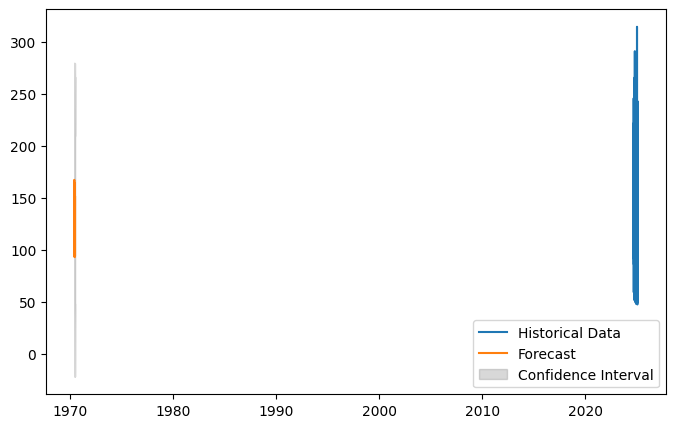

In [414]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(df_train, label="Historical Data")
plt.plot(range(len(df_train), len(df_train) + len(forecast_values)), forecast_values, label="Forecast")
plt.fill_between(
    range(len(df_train), len(df_train) + len(forecast_values)),
    conf_int.iloc[:, 0],  # Lower bound
    conf_int.iloc[:, 1],  # Upper bound
    color="gray", alpha=0.3, label="Confidence Interval"
)
plt.legend()
plt.show()

In [73]:
df1.tail(30)

,y,arimaPred
ds,,
2025-02-05,105.4,NaN
2025-02-06,140.0,140.891101
2025-02-07,146.2,167.139892
2025-02-08,205.1,150.634274
2025-02-09,296.8,155.798900
2025-02-10,106.0,134.188390
2025-02-11,157.9,107.078102
2025-02-12,105.2,93.545364
2025-02-13,71.1,144.526269


In [74]:
np.sqrt(mean_squared_error(df_test['y'],prediction))

np.float64(70.17184791396292)

<Axes: xlabel='ds', ylabel='y'>

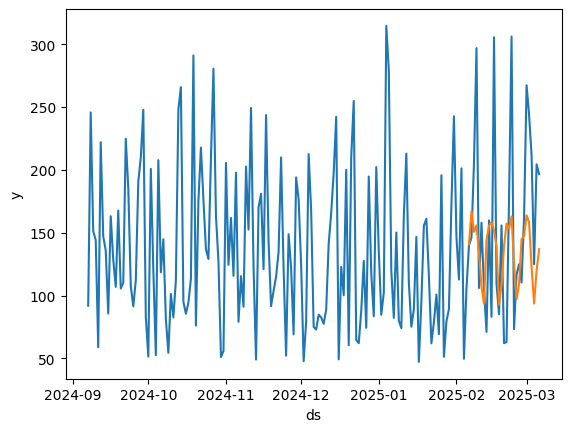

In [75]:
sns.lineplot(data=df1,x=df1.index,y='y')
sns.lineplot(data=df1,x=df1.index,y='arimaPred')

In [160]:
model = SARIMAX(df_train['y'],order=(2,0,4),seasonal_order=(2,1,2,7), freq='D')
model_fit = model.fit()
prediction = model_fit.predict(start=df_test.index[0],end=df_test.index[-1])
df1['sarimaxPred'] = prediction

c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [161]:
df1.tail(30)

,y,arimaPred,sarimaxPred
ds,,,
2025-02-05,105.4,NaN,NaN
2025-02-06,140.0,140.891101,151.321472
2025-02-07,146.2,167.139892,126.095343
2025-02-08,205.1,150.634274,159.050504
2025-02-09,296.8,155.798900,189.616062
2025-02-10,106.0,134.188390,130.857423
2025-02-11,157.9,107.078102,110.425098
2025-02-12,105.2,93.545364,97.477150
2025-02-13,71.1,144.526269,127.039161


In [162]:
np.sqrt(mean_squared_error(df_test['y'],prediction))

np.float64(62.91094152516237)

C:\Users\Uttam Kumar\AppData\Local\Temp\ipykernel_7252\1647108016.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Category')


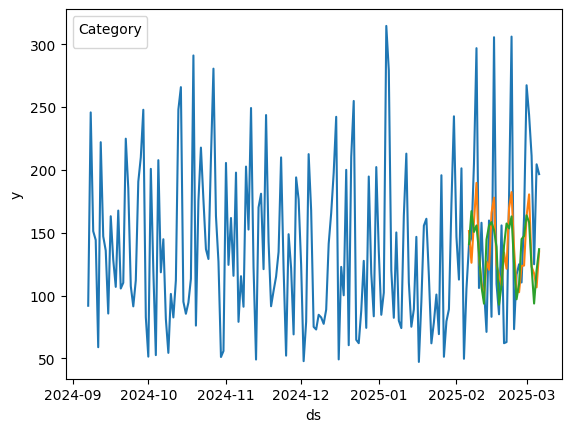

In [168]:
sns.lineplot(data=df1,x=df1.index,y='y')
sns.lineplot(data=df1,x=df1.index,y='sarimaxPred')
sns.lineplot(data=df1,x=df1.index,y='arimaPred')

<Axes: xlabel='ds'>

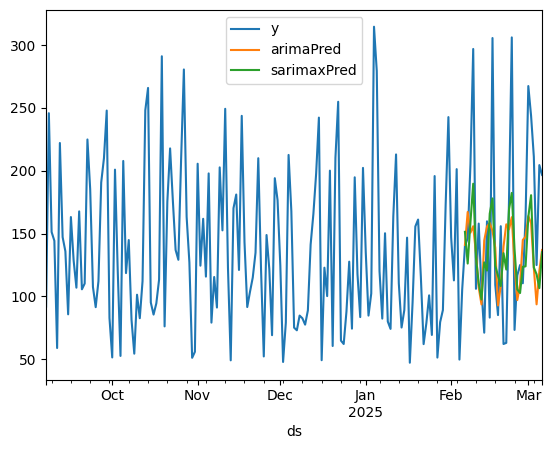

In [173]:
# df1['y'].plot()
# df1['sarimaxPred'].plot()
# df1['arimaPred'].plot()
df1.plot()

In [215]:
#Holtwinter model
hwmodel=ExponentialSmoothing(df_train.y,trend='add', seasonal='add', seasonal_periods=12).fit(\
    smoothing_level=0.1, smoothing_trend=0.2, smoothing_seasonal=0.8)

In [200]:
df_test.index[0:-1]

DatetimeIndex(['2025-02-06', '2025-02-07', '2025-02-08', '2025-02-09',
               '2025-02-10', '2025-02-11', '2025-02-12', '2025-02-13',
               '2025-02-14', '2025-02-15', '2025-02-16', '2025-02-17',
               '2025-02-18', '2025-02-19', '2025-02-20', '2025-02-21',
               '2025-02-22', '2025-02-23', '2025-02-24', '2025-02-25',
               '2025-02-26', '2025-02-27', '2025-02-28', '2025-03-01',
               '2025-03-02', '2025-03-03', '2025-03-04', '2025-03-05'],
              dtype='datetime64[ns]', name='ds', freq='D')

In [216]:
hwmodelPred = hwmodel.forecast(29)
df1['hwmodelPred'] = hwmodelPred

In [197]:
hwmodelPred.head(30)

2025-02-06    220.757787
2025-02-07    251.905207
2025-02-08    125.932466
2025-02-09     94.858766
2025-02-10    154.455734
2025-02-11     10.309364
2025-02-12    125.499412
2025-02-13    187.977156
2025-02-14    219.124576
2025-02-15     93.151836
2025-02-16     62.078135
2025-02-17    121.675103
2025-02-18    -22.471266
2025-02-19     92.718781
2025-02-20    155.196526
2025-02-21    186.343945
2025-02-22     60.371205
2025-02-23     29.297505
2025-02-24     88.894473
2025-02-25    -55.251897
2025-02-26     59.938150
2025-02-27    122.415895
2025-02-28    153.563315
2025-03-01     27.590575
2025-03-02     -3.483126
2025-03-03     56.113842
2025-03-04    -88.032528
2025-03-05     27.157520
2025-03-06     89.635265
Freq: D, dtype: float64

In [217]:
np.sqrt(mean_squared_error(df_test['y'], hwmodelPred))

np.float64(97.66736631778248)

In [218]:
df1.tail(30)

,y,arimaPred,sarimaxPred,hwmodelPred
ds,,,,
2025-02-05,105.4,NaN,NaN,NaN
2025-02-06,140.0,140.891101,151.321472,108.323729
2025-02-07,146.2,167.139892,126.095343,207.494528
2025-02-08,205.1,150.634274,159.050504,84.913465
2025-02-09,296.8,155.798900,189.616062,127.416619
2025-02-10,106.0,134.188390,130.857423,128.997769
2025-02-11,157.9,107.078102,110.425098,203.103741
2025-02-12,105.2,93.545364,97.477150,263.592042
2025-02-13,71.1,144.526269,127.039161,181.403708


In [221]:
df1.y.mean(), np.sqrt(df1.y.var())

(np.float64(138.66077348066298), np.float64(63.87682728378772))

<Axes: xlabel='ds'>

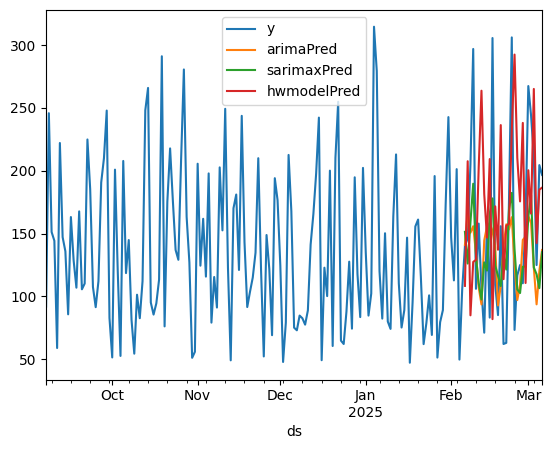

In [219]:
df1.plot()

<Axes: xlabel='ds'>

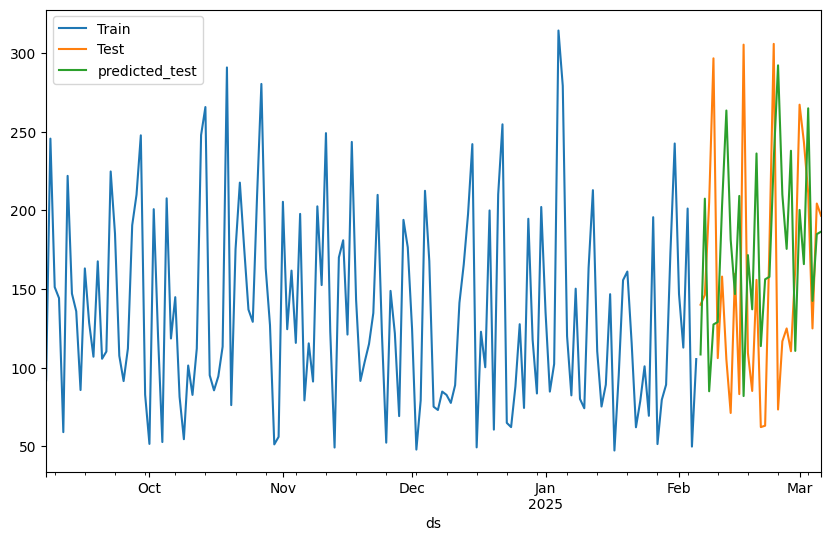

In [220]:
df_train['y'].plot(legend=True, label='Train', figsize=(10,6))
df_test['y'].plot(legend=True, label='Test')

hwmodelPred.plot(legend=True, label='predicted_test')

In [256]:
df1.tail()

,y,arimaPred,sarimaxPred,hwmodelPred,rollMean,rollStd
ds,,,,,,
2025-03-02,243.7,158.248310,180.476526,165.823083,155.316667,80.895857
2025-03-03,211.1,122.622444,122.978104,264.993882,159.925000,82.485394
2025-03-04,124.9,93.645838,117.592387,142.412819,165.158333,77.559718
2025-03-05,204.4,120.067057,106.519591,184.915973,176.941667,71.100460
2025-03-06,196.6,136.888165,135.119341,186.497123,178.525000,71.327645


In [257]:
df1.drop(['rollMean', 'rollStd'], axis=1, inplace=True)

In [258]:
df1.tail()

,y,arimaPred,sarimaxPred,hwmodelPred
ds,,,,
2025-03-02,243.7,158.248310,180.476526,165.823083
2025-03-03,211.1,122.622444,122.978104,264.993882
2025-03-04,124.9,93.645838,117.592387,142.412819
2025-03-05,204.4,120.067057,106.519591,184.915973
2025-03-06,196.6,136.888165,135.119341,186.497123


In [270]:
#Prophet model
prophet_train_data = df_train.reset_index()
prophet_test_data = df_test.reset_index()
prophet_train_data.head()

,ds,y
0,2024-09-07,91.9
1,2024-09-08,245.7
2,2024-09-09,151.2
3,2024-09-10,144.2
4,2024-09-11,58.9


In [275]:
prophet_test_data.head()

,ds,y
0,2025-02-06,140.0
1,2025-02-07,146.2
2,2025-02-08,205.1
3,2025-02-09,296.8
4,2025-02-10,106.0


In [417]:
model = Prophet(changepoint_prior_scale=0.002, seasonality_prior_scale=10.0, weekly_seasonality=True, interval_width=0.95)
model.add_country_holidays(country_name='US')

In [269]:
df_train.head()

,y
ds,
2024-09-07,91.9
2024-09-08,245.7
2024-09-09,151.2
2024-09-10,144.2
2024-09-11,58.9


In [339]:
df_train.shape

(152, 1)

In [418]:
model.fit(prophet_train_data)

04:38:10 - cmdstanpy - INFO - Chain [1] start processing
04:38:10 - cmdstanpy - INFO - Chain [1] done processing
04:38:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:38:10 - cmdstanpy - INFO - Chain [1] start processing
04:38:10 - cmdstanpy - INFO - Chain [1] done processing


In [393]:
model.seasonalities

OrderedDict([('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 30.0,
               'mode': 'additive',
               'condition_name': None})])

In [394]:
model.component_modes

{'additive': ['weekly',
  "New Year's Day",
  'Memorial Day',
  'Juneteenth National Independence Day',
  'Independence Day',
  'Labor Day',
  'Veterans Day',
  'Thanksgiving',
  'Christmas Day',
  'Martin Luther King Jr. Day',
  "Washington's Birthday",
  'Columbus Day',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [395]:
future_dates = model.make_future_dataframe(periods=29)

In [323]:
future_dates

,ds
0,2024-09-07
1,2024-09-08
2,2024-09-09
3,2024-09-10
4,2024-09-11
...,...
177,2025-03-03
178,2025-03-04
179,2025-03-05
180,2025-03-06


In [419]:
prophetPredData = model.predict(future_dates) #['yhat'] #prophet_test_data[['ds']]

In [325]:
model.train_holiday_names
us_holidays = model.holidays
print(us_holidays)

None


In [420]:
prophetPredData.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-09-07,143.252863,79.264786,280.394992,143.252863,143.252863,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,33.406836,33.406836,33.406836,0.0,0.0,0.0,176.659699
1,2024-09-08,143.119407,88.403043,286.697371,143.119407,143.119407,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,48.047763,48.047763,48.047763,0.0,0.0,0.0,191.167171
2,2024-09-09,142.985952,21.193207,218.879186,142.985952,142.985952,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-17.916116,-17.916116,-17.916116,0.0,0.0,0.0,125.069835
3,2024-09-10,142.852496,26.780555,222.634606,142.852496,142.852496,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-21.036490,-21.036490,-21.036490,0.0,0.0,0.0,121.816006
4,2024-09-11,142.719040,9.510264,218.206984,142.719040,142.719040,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-29.364870,-29.364870,-29.364870,0.0,0.0,0.0,113.354170


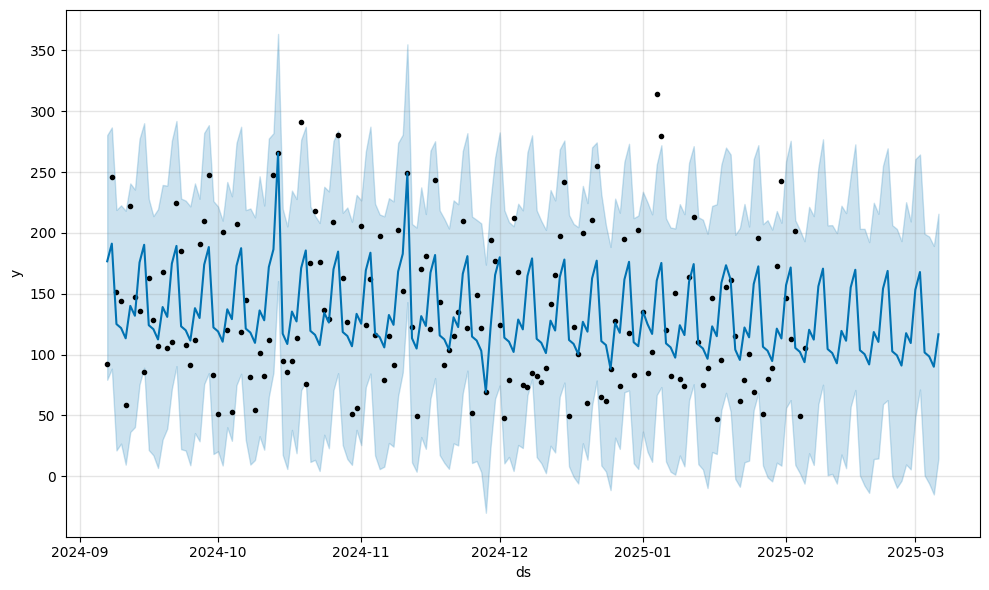

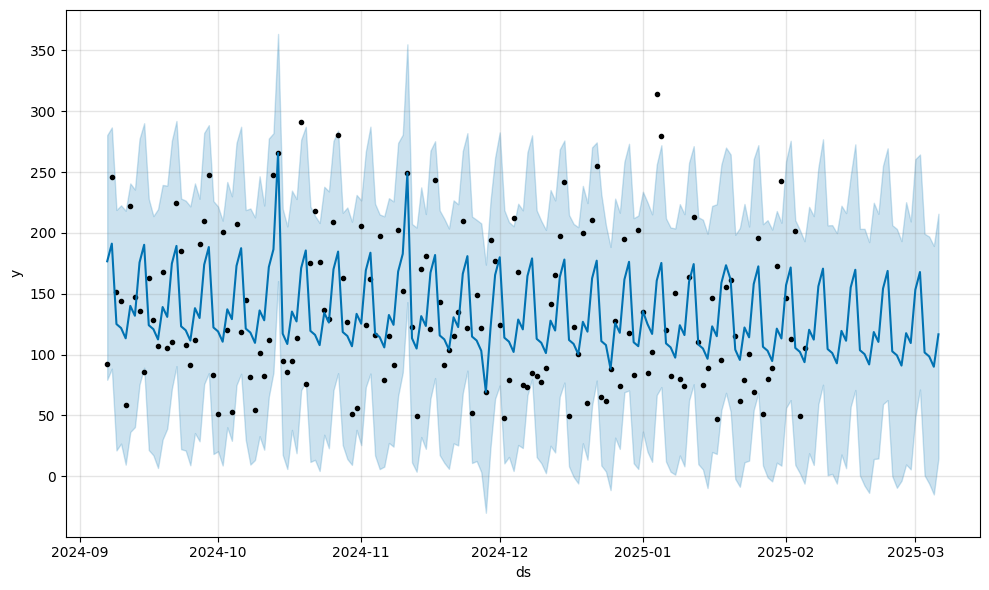

In [421]:
#### plot the predicted projection
#Visualizing Confidence Intervals in Prophet
model.plot(prophetPredData)

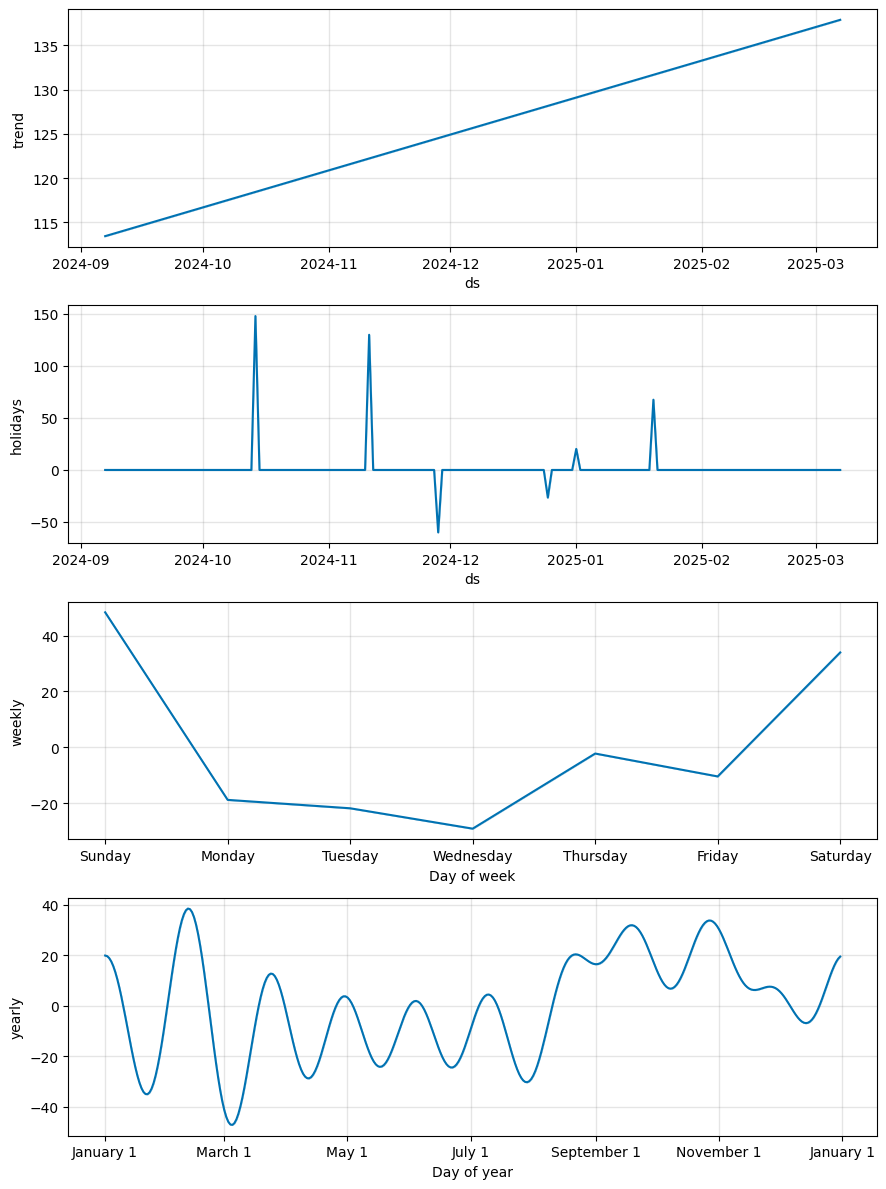

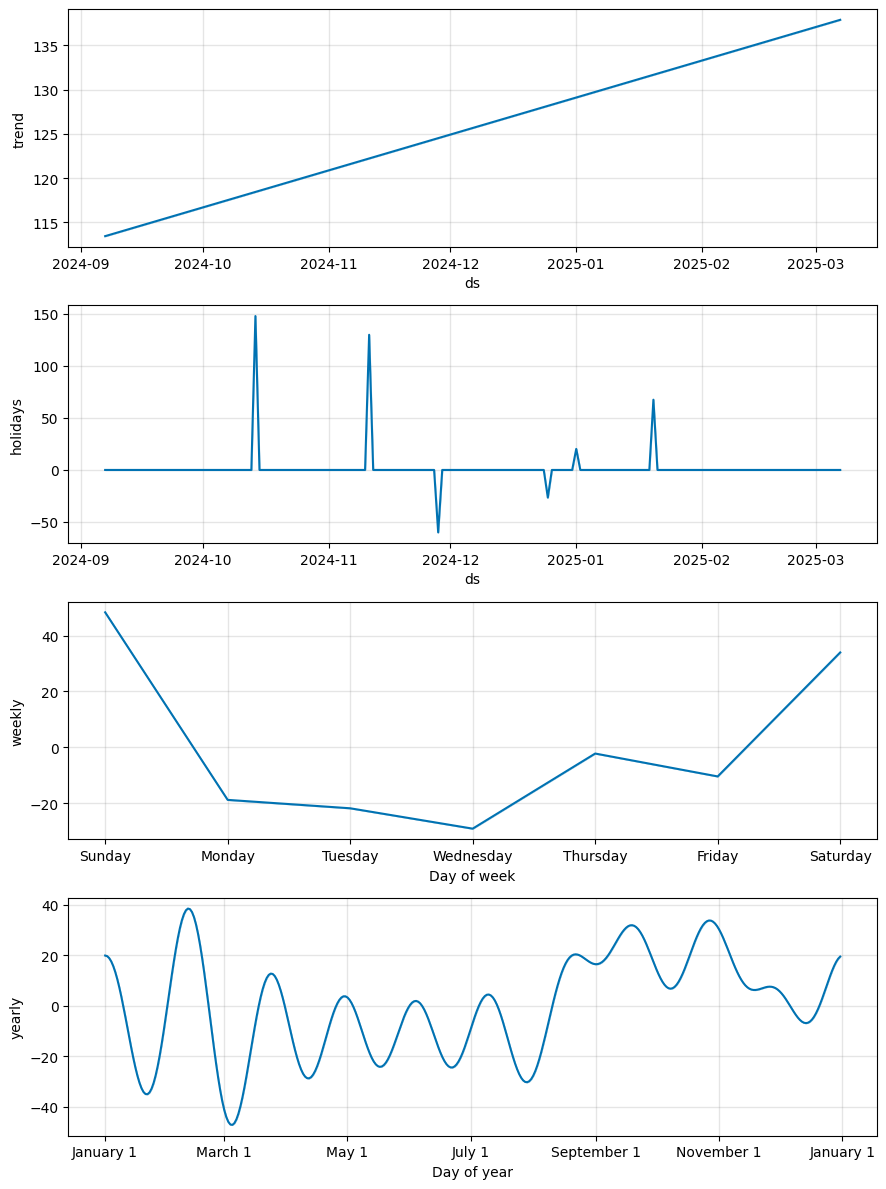

In [329]:
##### Visualize Each Components[Trends,Weekly]
model.plot_components(prophetPredData)

In [330]:
#Cross Validation
from prophet.diagnostics import cross_validation

In [344]:
df_cv=cross_validation(model, horizon='10 days', initial='30 days') #horizon="60 days", period='30 days',initial='152 days'

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/23 [00:00<?, ?it/s]03:46:12 - cmdstanpy - INFO - Chain [1] start processing
03:46:13 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 1/23 [00:00<00:06,  3.55it/s]03:46:13 - cmdstanpy - INFO - Chain [1] start processing
03:46:13 - cmdstanpy - INFO - Chain [1] done processing
  9%|▊         | 2/23 [00:00<00:10,  2.01it/s]03:46:13 - cmdstanpy - INFO - Chain [1] start processing
03:46:14 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 3/23 [00:01<00:08,  2.50it/s]03:46:14 - cmdstanpy - INFO - Chain [1] start processing
03:46:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 4/23 [00:01<00:06,  2.79it/s]03:46:14 - cmdstanpy - INFO - Chain [1] start processing
03:46:14 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 5/23 [00:01<00:05,  3.01it/s]03:46:14 - cmdstanpy - INFO - Chain [1] start processing
03:46:

In [345]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2024-10-09,110.859188,53.278373,171.962919,54.4,2024-10-08
1,2024-10-10,175.573442,114.856713,234.594257,101.3,2024-10-08
2,2024-10-11,177.004515,113.897810,236.132630,82.6,2024-10-08
3,2024-10-12,249.878110,196.379062,307.353548,112.1,2024-10-08
4,2024-10-13,331.731521,270.609782,393.726788,248.0,2024-10-08


In [385]:
from prophet.diagnostics import performance_metrics
df_performance=performance_metrics(df_cv)
df_performance.tail(30)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,4784.686696,69.171430,55.143768,0.550043,0.331149,0.429260,0.652174
1,2 days,4850.614015,69.646350,54.536556,0.541488,0.312514,0.462648,0.608696
2,3 days,10576.506940,102.842146,89.630031,0.821320,0.715279,0.710773,0.304348
3,4 days,17515.147627,132.344806,103.001974,0.851340,0.534231,0.723851,0.391304
4,5 days,27995.075096,167.317289,128.022048,1.138196,0.670122,0.803418,0.347826
5,6 days,34680.790626,186.227792,134.865711,1.314929,0.760214,0.839354,0.434783
6,7 days,63435.003664,251.863065,189.896809,1.799007,1.372487,1.020073,0.260870
7,8 days,104606.327021,323.429014,238.442677,1.897004,1.709753,1.055177,0.304348
8,9 days,146404.380055,382.628253,278.021234,2.622352,1.414491,1.052795,0.304348
9,10 days,226140.462523,475.542283,344.210207,2.913201,2.292663,1.114203,0.260870


c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


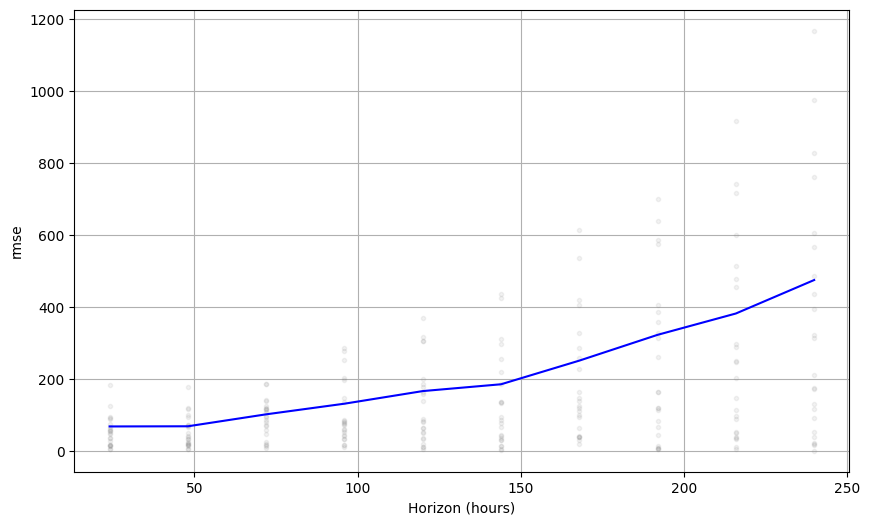

In [347]:
from prophet.plot import plot_cross_validation_metric
fig=plot_cross_validation_metric(df_cv,metric='rmse')

In [422]:
prophetPred = prophetPredData[['ds', 'yhat']].rename(columns={"yhat": "prophetPred"})

In [368]:
prophetPred.head()

,ds,prophetPred
0,2024-09-07,170.008989
1,2024-09-08,188.242627
2,2024-09-09,138.668054
3,2024-09-10,122.657435
4,2024-09-11,117.544064


In [423]:
df1_reset = df1.reset_index()
df1_reset.rename(columns={'index': 'ds'}, inplace=True)  # Rename index to 'ds'

final_df = pd.merge(df1_reset, prophetPred, on='ds', how="left")
final_df.set_index('ds', inplace=True)

In [424]:
final_df.tail(32)

,y,arimaPred,sarimaxPred,hwmodelPred,prophetPred
ds,,,,,
2025-02-03,201.2,NaN,NaN,NaN,105.451851
2025-02-04,49.7,NaN,NaN,NaN,102.198021
2025-02-05,105.4,NaN,NaN,NaN,93.736185
2025-02-06,140.0,140.891101,151.321472,108.323729,120.381120
2025-02-07,146.2,167.139892,126.095343,207.494528,112.283501
2025-02-08,205.1,150.634274,159.050504,84.913465,156.107524
2025-02-09,296.8,155.798900,189.616062,127.416619,170.614996
2025-02-10,106.0,134.188390,130.857423,128.997769,104.517661
2025-02-11,157.9,107.078102,110.425098,203.103741,101.263831


<Axes: xlabel='ds'>

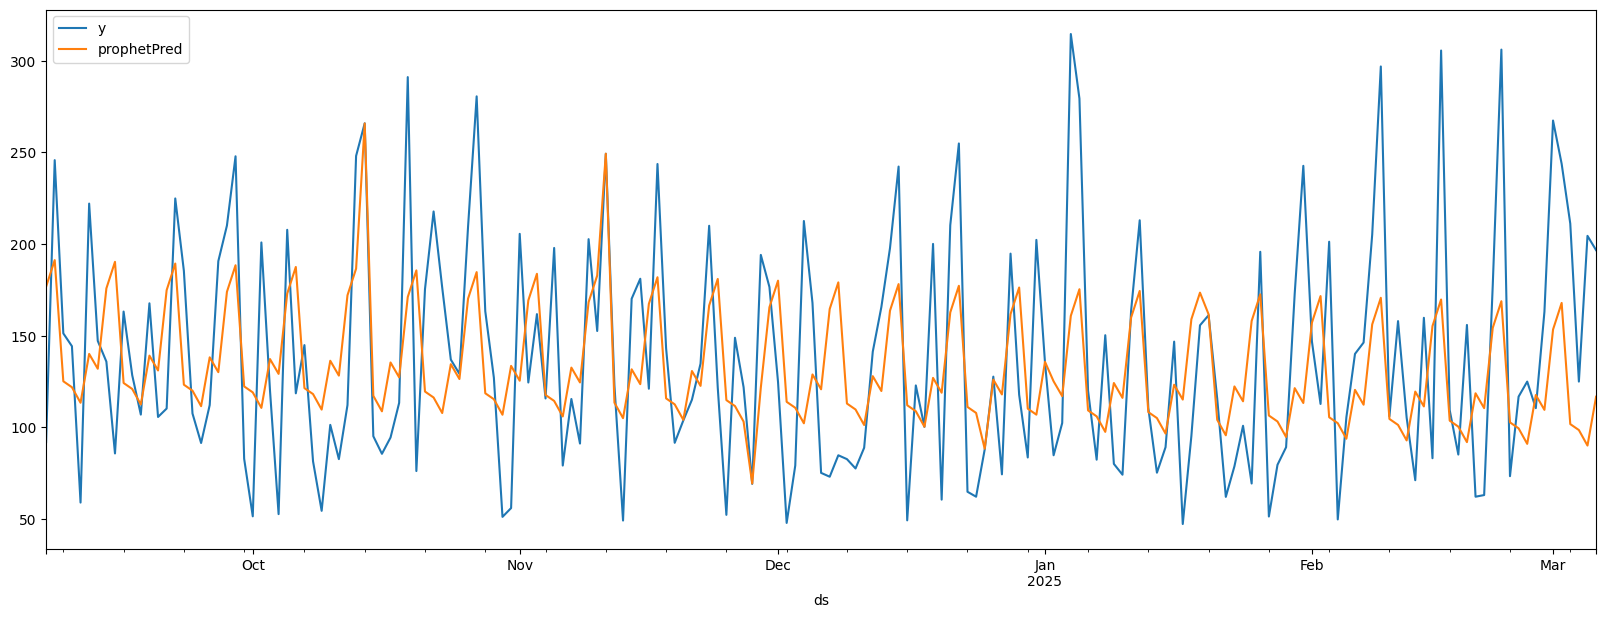

In [427]:
final_df[['y', 'prophetPred']].plot(figsize=(20, 7))

In [428]:
np.sqrt(mean_squared_error(df1['y'], prophetPred['prophetPred']))

np.float64(55.36036135630217)

In [378]:
df1.shape

(181, 4)

In [379]:
prophetPred.shape

(182, 2)

In [381]:
df1

,y,arimaPred,sarimaxPred,hwmodelPred
ds,,,,
2024-09-07,91.9,NaN,NaN,NaN
2024-09-08,245.7,NaN,NaN,NaN
2024-09-09,151.2,NaN,NaN,NaN
2024-09-10,144.2,NaN,NaN,NaN
2024-09-11,58.9,NaN,NaN,NaN
...,...,...,...,...
2025-03-02,243.7,158.248310,180.476526,165.823083
2025-03-03,211.1,122.622444,122.978104,264.993882
2025-03-04,124.9,93.645838,117.592387,142.412819


In [380]:
prophetPred

,ds,prophetPred
0,2024-09-07,170.008989
1,2024-09-08,188.242627
2,2024-09-09,138.668054
3,2024-09-10,122.657435
4,2024-09-11,117.544064
...,...,...
177,2025-03-03,112.208429
178,2025-03-04,94.066838
179,2025-03-05,87.424545
180,2025-03-06,112.288264
